# Paper ST Sloping - 64 beats

## Setup

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix
from imblearn.metrics import classification_report_imbalanced
import random
import time

In [2]:
THREADS_TO_USE = 4

In [3]:
def parse_accuracy_per_class(conf_matrix, classes):
    acc_per_class = dict()
    for i, c in enumerate(classes):
        tn, fp, fn, tp = conf_matrix[i].ravel()
        acc_per_class[c] = (tp + tn) /(tp + tn + fp + fn)
    return acc_per_class

## Load dataset

In [4]:
data = pd.read_csv('../dataset/st_dataset_64beats.csv')
data = data.dropna()
data.head()

,id,dw_1,dw_2,dw_3,dw_4,dw_5,mfw_1,mfw_2,mfw_3,mfw_4,...,cfr_8,cfr_9,cfr_10,cfr_11,cfr_12,cfr_13,cfr_14,cfr_15,cfr_16,label
0,e0106,267.535629,270.981533,270.243834,76.791207,11.207306,0.483334,-0.435149,-0.637676,-0.096703,...,-0.047331,0.034527,-0.042788,0.048729,-0.072291,0.006842,-0.025811,-0.008343,-0.007415,NSR
1,e0106,277.949875,283.546637,283.543383,80.370321,11.621628,0.480582,-0.437337,-0.666380,-0.138188,...,-0.053865,0.034099,-0.034026,0.038144,-0.071427,0.011442,-0.027634,-0.009450,-0.002719,NSR
2,e0106,280.952321,289.729213,288.768479,81.676148,11.842770,0.479468,-0.434101,-0.641674,-0.075015,...,-0.041838,0.031072,-0.035728,0.040951,-0.067828,0.007170,-0.022649,-0.013308,-0.001871,NSR
3,e0106,266.093352,277.366979,279.066959,79.365536,11.515873,0.479998,-0.433339,-0.648197,-0.093792,...,-0.047719,0.029625,-0.035988,0.049478,-0.081219,0.019213,-0.029185,-0.014198,-0.000186,NSR
4,e0106,279.838160,290.933842,289.849559,81.839924,11.791220,0.479852,-0.432266,-0.660649,-0.107788,...,-0.050448,0.030725,-0.035125,0.042994,-0.070263,0.010677,-0.027446,-0.011952,-0.001447,NSR


In [5]:
data['label'].value_counts()

NSR    6531
ST-    1377
ST+     613
Name: label, dtype: int64

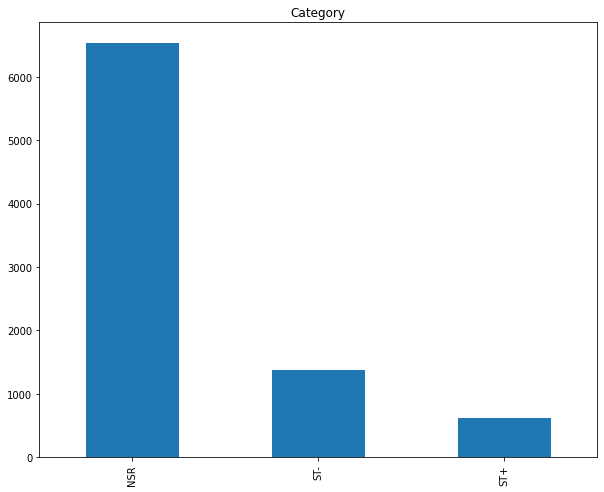

In [6]:
data['label'].value_counts().plot(kind='bar', title='Category', figsize=(10,8))
plt.show()

In [7]:
data.corr()

,dw_1,dw_2,dw_3,dw_4,dw_5,mfw_1,mfw_2,mfw_3,mfw_4,mfw_5,...,cfr_7,cfr_8,cfr_9,cfr_10,cfr_11,cfr_12,cfr_13,cfr_14,cfr_15,cfr_16
dw_1,1.000000,0.273382,0.122628,0.083674,0.051094,0.221600,-0.049649,0.078730,-0.012908,0.013862,...,-0.117220,-0.037767,-0.071736,-0.046960,-0.038058,-0.092294,-0.054016,-0.072729,-0.130987,-0.124267
dw_2,0.273382,1.000000,0.838009,0.506753,0.191967,0.386284,-0.517805,-0.334992,-0.004812,0.033948,...,-0.102493,0.182840,0.234210,0.178912,0.060450,0.039959,0.136143,0.005734,-0.118431,-0.066128
dw_3,0.122628,0.838009,1.000000,0.707121,0.290188,0.236678,-0.561877,-0.475222,0.011125,0.014124,...,-0.197277,0.158323,0.273116,0.121813,-0.051209,0.069581,0.038555,-0.024726,-0.136079,-0.044854
dw_4,0.083674,0.506753,0.707121,1.000000,0.871892,-0.017655,-0.285199,-0.270161,0.009232,0.003634,...,-0.149766,0.073674,0.107847,0.080194,-0.042344,0.051053,0.026543,-0.037506,-0.119712,-0.043279
dw_5,0.051094,0.191967,0.290188,0.871892,1.000000,-0.129453,-0.030009,-0.050190,0.002565,-0.000720,...,-0.059404,0.011401,-0.015802,0.062258,0.002897,0.013172,0.024296,-0.044898,-0.070291,-0.028559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cfr_12,-0.092294,0.039959,0.069581,0.051053,0.013172,-0.160514,0.118367,0.127268,-0.005908,0.006278,...,-0.134908,-0.218479,-0.043561,0.050509,0.078646,1.000000,0.025204,0.020729,-0.368802,-0.228329
cfr_13,-0.054016,0.136143,0.038555,0.026543,0.024296,0.066207,-0.006270,0.019160,0.007572,-0.003219,...,0.180735,0.047865,-0.208494,-0.263557,0.025616,0.025204,1.000000,0.246144,0.176991,-0.125499
cfr_14,-0.072729,0.005734,-0.024726,-0.037506,-0.044898,-0.013333,0.037817,0.030309,0.006547,-0.008574,...,0.131588,0.237481,0.033791,-0.177838,-0.278564,0.020729,0.246144,1.000000,0.233453,-0.128832
cfr_15,-0.130987,-0.118431,-0.136079,-0.119712,-0.070291,0.043544,0.078133,0.032731,0.009685,-0.019258,...,0.301428,0.154375,-0.085936,-0.131212,-0.053772,-0.368802,0.176991,0.233453,1.000000,0.371065


In [8]:
y = data['label'].values
X = data.loc[:, ~data.columns.isin(["id", "label"])].copy()

In [9]:
label_encoder = LabelEncoder().fit(y)
y = label_encoder.transform(y)

## Feature selection

### Exclude features with corr > 0.95

In [10]:
correlated_features = set()
correlation_matrix = X.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.95:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [11]:
print(correlated_features)

{'fft_139', 'fft_227', 'fft_162', 'fft_232', 'fft_207', 'fft_209', 'fft_131', 'fft_147', 'fft_144', 'fft_172', 'fft_181', 'fft_149', 'fft_193', 'fft_220', 'fft_177', 'fft_180', 'fft_195', 'fft_238', 'fft_174', 'fft_242', 'fft_255', 'fft_225', 'mfw_14', 'fft_228', 'fft_204', 'fft_169', 'fft_152', 'fft_176', 'fft_239', 'fft_191', 'fft_200', 'fft_223', 'fft_194', 'fft_203', 'mfw_16', 'fft_236', 'fft_256', 'fft_211', 'fft_133', 'fft_252', 'fft_222', 'fft_140', 'fft_155', 'fft_160', 'fft_173', 'fft_163', 'fft_241', 'fft_245', 'fft_230', 'fft_190', 'fft_164', 'fft_146', 'fft_130', 'fft_210', 'fft_217', 'fft_235', 'fft_208', 'cfr_16', 'fft_161', 'mfw_7', 'fft_198', 'fft_226', 'fft_254', 'fft_170', 'fft_213', 'fft_134', 'fft_143', 'fft_253', 'fft_166', 'fft_150', 'fft_247', 'fft_182', 'fft_251', 'mfw_15', 'fft_216', 'fft_231', 'fft_136', 'fft_249', 'fft_179', 'fft_158', 'fft_199', 'fft_186', 'fft_197', 'fft_141', 'fft_151', 'fft_165', 'fft_138', 'fft_137', 'fft_250', 'fft_237', 'fft_145', 'fft

### Random forest embeded for features selection

In [12]:
cols_no_corr = [col for col in X.columns if col not in correlated_features]

In [13]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(random_state=101, n_jobs=THREADS_TO_USE), threshold='1.25*median')
embeded_rf_selector.fit(X[cols_no_corr], y)

SelectFromModel(estimator=RandomForestClassifier(n_jobs=4, random_state=101),
                threshold='1.25*median')

In [14]:
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X[cols_no_corr].loc[:,embeded_rf_support].columns.tolist()

print('\n'.join(embeded_rf_feature), '\nselected features:', len(embeded_rf_feature))

dw_1
dw_2
dw_3
dw_4
dw_5
mfw_1
mfw_2
mfw_3
mfw_4
fft_1
fft_2
fft_3
fft_4
fft_5
fft_6
fft_7
fft_8
fft_9
fft_10
fft_11
fft_12
fft_13
fft_14
fft_15
fft_17
fft_19
fft_20
fft_21
fft_22
fft_24
fft_26
fft_27
fft_28
fft_29
fft_30
fft_32
fft_33
fft_34
fft_35
fft_36
fft_37
ar_1
ar_2
ar_3
ar_4
ar_5
ar_6
ar_7
ar_8
ar_9
ar_10
ar_11
ar_12
ar_13
ar_14
ar_15
ar_16
var
cfr_1
cfr_2
cfr_3
cfr_4
cfr_5
cfr_6
cfr_7
cfr_8
cfr_9
cfr_10
cfr_11
cfr_12
cfr_13
cfr_14
cfr_15 
selected features: 73


### Visualization best features

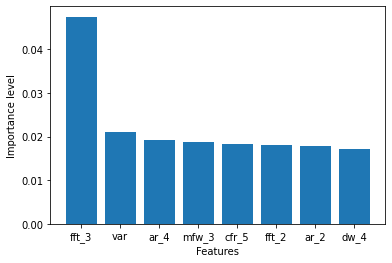

In [15]:
features_dict = dict(zip(cols_no_corr, embeded_rf_selector.estimator_.feature_importances_))
features_dict = dict(sorted(features_dict.items(), key=lambda item: item[1], reverse=True))

best_features = dict()
for index, (key, value) in enumerate(features_dict.items()):
    if index < 8:
        best_features[key] = value

plt.bar(range(len(best_features)), list(best_features.values()), align='center', )
plt.xticks(ticks=range(len(best_features)), labels=best_features.keys())
plt.xlabel('Features')
plt.ylabel('Importance level')
plt.show()

## Filter features

In [16]:
X_fsel = X[embeded_rf_feature]
X_fsel.head()

,dw_1,dw_2,dw_3,dw_4,dw_5,mfw_1,mfw_2,mfw_3,mfw_4,fft_1,...,cfr_6,cfr_7,cfr_8,cfr_9,cfr_10,cfr_11,cfr_12,cfr_13,cfr_14,cfr_15
0,267.535629,270.981533,270.243834,76.791207,11.207306,0.483334,-0.435149,-0.637676,-0.096703,-1.065012,...,0.016873,0.040724,-0.047331,0.034527,-0.042788,0.048729,-0.072291,0.006842,-0.025811,-0.008343
1,277.949875,283.546637,283.543383,80.370321,11.621628,0.480582,-0.437337,-0.666380,-0.138188,-2.207264,...,0.011581,0.052652,-0.053865,0.034099,-0.034026,0.038144,-0.071427,0.011442,-0.027634,-0.009450
2,280.952321,289.729213,288.768479,81.676148,11.842770,0.479468,-0.434101,-0.641674,-0.075015,-0.855778,...,0.031430,0.033720,-0.041838,0.031072,-0.035728,0.040951,-0.067828,0.007170,-0.022649,-0.013308
3,266.093352,277.366979,279.066959,79.365536,11.515873,0.479998,-0.433339,-0.648197,-0.093792,-1.105237,...,0.018259,0.048839,-0.047719,0.029625,-0.035988,0.049478,-0.081219,0.019213,-0.029185,-0.014198
4,279.838160,290.933842,289.849559,81.839924,11.791220,0.479852,-0.432266,-0.660649,-0.107788,14.855103,...,0.015173,0.050778,-0.050448,0.030725,-0.035125,0.042994,-0.070263,0.010677,-0.027446,-0.011952


## Random Forest - 1000x random split

In [17]:
classes = np.unique(label_encoder.inverse_transform(y))

result_df = pd.DataFrame()

split_seeds = random.sample(range(1, 2**32 - 1), 1000)
smote_seeds = random.sample(range(1, 2**32 - 1), 1000)
for i, (split_seed, smote_seed) in enumerate(zip(split_seeds, smote_seeds)):
    start_time = time.time()

    # Train and Test split
    x_train, x_test, y_train, y_test = train_test_split(X_fsel, y, test_size=0.2, random_state=split_seed)
    smote = SMOTE(random_state=smote_seed, n_jobs=THREADS_TO_USE)
    x_smote, y_smote = smote.fit_resample(x_train, y_train)

    # Training
    model = RandomForestClassifier(random_state=101, n_jobs=THREADS_TO_USE).fit(x_smote, y_smote)

    # Prediction
    y_pred = model.predict(x_test)

    # Decode
    y_test_dec = label_encoder.inverse_transform(y_test)
    y_pred_dec = label_encoder.inverse_transform(y_pred)

    # get metrics
    report = classification_report_imbalanced(y_true=y_test_dec, y_pred=y_pred_dec, labels=label_encoder.classes_, zero_division=1, output_dict=True)
    confusion_matrix = multilabel_confusion_matrix(y_pred=y_pred_dec, y_true=y_test_dec, labels=classes)

    # TOTAL
    tot_accuracy    = accuracy_score(y_true=y_test_dec, y_pred=y_pred_dec)
    tot_precision   = report['avg_pre']
    tot_recall      = report['avg_rec']
    tot_specificity = report['avg_spe']
    tot_f1          = report['avg_f1']

    # NSR
    nsr_accuracy    = parse_accuracy_per_class(confusion_matrix, classes)['NSR']
    nsr_precision   = report['NSR']['pre']
    nsr_recall      = report['NSR']['rec']
    nsr_specificity = report['NSR']['spe']
    nsr_f1          = report['NSR']['f1']

    # ST+
    st1_accuracy    = parse_accuracy_per_class(confusion_matrix, classes)['ST+']
    st1_precision   = report['ST+']['pre']
    st1_recall      = report['ST+']['rec']
    st1_specificity = report['ST+']['spe']
    st1_f1          = report['ST+']['f1']

    # ST-
    st0_accuracy    = parse_accuracy_per_class(confusion_matrix, classes)['ST+']
    st0_precision   = report['ST-']['pre']
    st0_recall      = report['ST-']['rec']
    st0_specificity = report['ST-']['spe']
    st0_f1          = report['ST-']['f1']

    # save result in result_df
    result_df = result_df.append({
        "accuracy": tot_accuracy,
        "precision": tot_precision,
        "recall": tot_recall,
        "specificity": tot_specificity,
        "f1": tot_f1,

        "nsr_accuracy": nsr_accuracy,
        "nsr_precision": nsr_precision,
        "nsr_recall": nsr_recall,
        "nsr_specificity": nsr_specificity,
        "nsr_f1": nsr_f1,

        "st+_accuracy": st1_accuracy,
        "st+_precision": st1_precision,
        "st+_recall": st1_recall,
        "st+_specificity": st1_specificity,
        "st+_f1": st1_f1,

        "st-_accuracy": st0_accuracy,
        "st-_precision": st0_precision,
        "st-_recall": st0_recall,
        "st-_specificity": st0_specificity,
        "st-_f1": st0_f1,
    }, ignore_index=True)
    end_time = time.time()

    elapsed_seconds = end_time - start_time
    # Log result
    print("#---------------------#")
    print(i+1, "of", len(split_seeds), "-", elapsed_seconds, "s")
    print("Tot: Accuracy", tot_accuracy, "Precision", tot_precision, "Recall", tot_recall, "Specificity", tot_specificity, "F1", tot_f1)
    print("NSR: Accuracy", nsr_accuracy, "Precision", nsr_precision, "Recall", nsr_recall, "Specificity", nsr_specificity, "F1", nsr_f1)
    print("ST+: Accuracy", st1_accuracy, "Precision", st1_precision, "Recall", st1_recall, "Specificity", st1_specificity, "F1", st1_f1)
    print("ST-: Accuracy", st0_accuracy, "precision", st0_precision, "Recall", st0_recall, "Specificity", st0_specificity, "F1", st0_f1)
    print("#---------------------#")

#---------------------#
1 of 1000 - 2.9880895614624023 s
Tot: Accuracy 0.9214076246334311 Precision 0.9218733332996838 Recall 0.9214076246334311 Specificity 0.8571922534578262 F1 0.9212685300671124
NSR: Accuracy 0.9225806451612903 Precision 0.9503759398496241 Recall 0.9503759398496241 Specificity 0.824 F1 0.9503759398496241
ST+: Accuracy 0.9777126099706744 Precision 0.7857142857142857 Recall 0.9 Specificity 0.9830721003134796 F1 0.8389830508474577
ST-: Accuracy 0.9777126099706744 precision 0.8353413654618473 Recall 0.7849056603773585 Specificity 0.9715277777777778 F1 0.8093385214007781
#---------------------#
#---------------------#
2 of 1000 - 3.001760959625244 s
Tot: Accuracy 0.9178885630498533 Precision 0.9186800916124318 Recall 0.9178885630498533 Specificity 0.8740518232451072 F1 0.9179525048489878
NSR: Accuracy 0.918475073313783 Precision 0.951048951048951 Recall 0.9415384615384615 Specificity 0.8444444444444444 F1 0.9462698105914187
ST+: Accuracy 0.9835777126099706 Precision 0.83

In [18]:
result_df.head(10)

,accuracy,precision,recall,specificity,f1,nsr_accuracy,nsr_precision,nsr_recall,nsr_specificity,nsr_f1,st+_accuracy,st+_precision,st+_recall,st+_specificity,st+_f1,st-_accuracy,st-_precision,st-_recall,st-_specificity,st-_f1
0,0.921408,0.921873,0.921408,0.857192,0.921269,0.922581,0.950376,0.950376,0.824000,0.950376,0.977713,0.785714,0.900000,0.983072,0.838983,0.977713,0.835341,0.784906,0.971528,0.809339
1,0.917889,0.918680,0.917889,0.874052,0.917953,0.918475,0.951049,0.941538,0.844444,0.946270,0.983578,0.835714,0.959016,0.985471,0.893130,0.983578,0.805755,0.791519,0.962025,0.798574
2,0.919648,0.919449,0.919648,0.862471,0.919424,0.919648,0.948777,0.946606,0.829949,0.947690,0.987097,0.876923,0.950000,0.989905,0.912000,0.987097,0.797753,0.777372,0.962264,0.787431
3,0.916129,0.915250,0.916129,0.825382,0.915314,0.916129,0.944077,0.950370,0.785915,0.947213,0.978886,0.816794,0.899160,0.984868,0.856000,0.978886,0.800000,0.728814,0.970728,0.762749
4,0.919648,0.921268,0.919648,0.878039,0.920165,0.920235,0.954370,0.941266,0.850254,0.947773,0.977126,0.800000,0.910569,0.982301,0.851711,0.977126,0.816176,0.819188,0.965132,0.817680
5,0.923167,0.922472,0.923167,0.862564,0.922726,0.923754,0.946524,0.953811,0.827586,0.950153,0.982991,0.866667,0.888889,0.989924,0.877637,0.982991,0.836957,0.799308,0.968220,0.817699
6,0.912610,0.914964,0.912610,0.865265,0.913120,0.912610,0.950617,0.935459,0.835052,0.942977,0.977713,0.768116,0.946429,0.979912,0.848000,0.977713,0.804428,0.789855,0.962911,0.797075
7,0.926686,0.925939,0.926686,0.877210,0.926158,0.927273,0.947860,0.955294,0.844186,0.951563,0.987097,0.893130,0.936000,0.991139,0.914063,0.987097,0.847751,0.803279,0.968571,0.824916
8,0.933724,0.933003,0.933724,0.878509,0.933141,0.933724,0.951835,0.961390,0.846341,0.956589,0.985924,0.888060,0.929688,0.990488,0.908397,0.985924,0.866920,0.808511,0.975404,0.836697
9,0.925513,0.924665,0.925513,0.853575,0.924528,0.926100,0.946777,0.958270,0.816537,0.952489,0.981232,0.845070,0.923077,0.986032,0.882353,0.981232,0.851528,0.758755,0.976519,0.802469


In [19]:
print("######## Total ########")
print("Accuracy",       result_df["accuracy"].mean())
print("Precision",      result_df["precision"].mean())
print("Recall",         result_df["recall"].mean())
print("Specificity",    result_df["specificity"].mean())
print("F1",             result_df["f1"].mean())

print("######## NSR ########")
print("Accuracy",       result_df["nsr_accuracy"].mean())
print("Precision",      result_df["nsr_precision"].mean())
print("Recall",         result_df["nsr_recall"].mean())
print("Specificity",    result_df["nsr_specificity"].mean())
print("F1",             result_df["nsr_f1"].mean())

print("######## ST+ ########")
print("Accuracy",       result_df["st+_accuracy"].mean())
print("Precision",      result_df["st+_precision"].mean())
print("Recall",         result_df["st+_recall"].mean())
print("Specificity",    result_df["st+_specificity"].mean())
print("F1",             result_df["st+_f1"].mean())

print("######## ST- ########")
print("Accuracy",       result_df["st-_accuracy"].mean())
print("Precision",      result_df["st-_precision"].mean())
print("Recall",         result_df["st-_recall"].mean())
print("Specificity",    result_df["st-_specificity"].mean())
print("F1",             result_df["st-_f1"].mean())

result_df.to_csv('result/multi_64beats_smote_1000x_random_split.csv')

######## Total ########
Accuracy 0.9225812316715541
Precision 0.9225629455981014
Recall 0.9225812316715541
Specificity 0.8653611155714683
F1 0.9222619556983412
######## NSR ########
Accuracy 0.9232639296187684
Precision 0.9489299836772778
Recall 0.9510854507598474
Specificity 0.832006654953684
F1 0.9499857701217287
######## ST+ ########
Accuracy 0.9810715542521995
Precision 0.8385090122036166
Recall 0.9136301278644975
Specificity 0.9863137691098063
F1 0.8739648982934959
######## ST- ########
Accuracy 0.9810715542521995
Precision 0.833889910024344
Recall 0.7914012585175874
Specificity 0.9696219231795323
F1 0.8117620750296474
